<a href="https://colab.research.google.com/github/skanderbenmansour/nlp_study_group/blob/master/tyler/colab/cloab_glove_lstm_batch_grid_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pack_sequence,pad_sequence,pack_padded_sequence,pad_packed_sequence
from torch.utils.data import TensorDataset, DataLoader

import pandas as pd
import numpy as np
import random

torch.manual_seed(1)

from tqdm.notebook import tqdm
from collections import Counter
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from gensim.models import KeyedVectors

import zipfile
from datetime import datetime
from glob import glob
import os
import json
import pickle
import sys
sys.path.append('/content/drive/My Drive/colab_data/')
import autoreload
%load_ext autoreload
%autoreload 2
from py_files import utils
from py_files import models

import tensorboard
%load_ext tensorboard
from torch.utils.tensorboard import SummaryWriter


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Set up GPU
#### Edit --> settings --> GPU

In [2]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    torch.backends.cudnn.enabled = True
    device_name = torch.cuda.get_device_name()
else:
    device = torch.device("cpu")
    device_name = 'cpu'

In [3]:
## Can force CPU for testing 
# device = torch.device("cpu")
# is_cuda = False

In [4]:
device,is_cuda,device_name

(device(type='cuda'), True, 'Tesla K80')

## Load data
Stanford data downloaded from https://ai.stanford.edu/~amaas/data/sentiment/

w2v data from https://www.kaggle.com/c/word2vec-nlp-tutorial/data

In [5]:
# data_path = '/content/drive/My Drive/colab_data/word2vec-nlp-tutorial/'
# train_data, test_data, val_data = utils.load_and_process_w2v_data(data_path,save=True)


In [6]:
data_path = '/content/drive/My Drive/colab_data/stanford_data/processed/'
# train_data, test_data, val_data = utils.load_raw_data(data_path,save=True)

## Prep reviews
25k train, 5k val, 20k test

In [7]:
train_data, test_data, val_data = utils.load_processed_reviews(data_path)

In [8]:
len(train_data),len(test_data),len(val_data)

(25000, 20000, 5000)

## Load glove

In [9]:
path = '/content/drive/My Drive/colab_data/glove/glove_100k_300d.kv'
glove = KeyedVectors.load(path)
weights = torch.FloatTensor(glove.vectors)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [10]:
word2idx = {word:idx for idx,word in enumerate(glove.vocab.keys())}

In [11]:
idx2word = {idx:word for word,idx in word2idx.items()}

## Prep input

In [12]:
batch_size = 100
train_loader,test_loader,val_loader = utils.load_all_tensor_data(train_data, test_data, val_data, batch_size, word2idx)

## Set up model

In [13]:
model_version = utils.get_run_version()
model_dir,log_dir = utils.setup_dir(model_version)

In [14]:
model_version,model_dir,log_dir

('v19',
 '/content/drive/My Drive/colab_data/model_checkpoints/v19',
 '/content/drive/My Drive/colab_data/model_checkpoints/v19/logs')

In [33]:
writer = SummaryWriter(log_dir)

In [30]:
num_labels = 2
vocab_size = 100000
embedding_dim = 300
num_layers = 1
hidden = 50
p_dropout = .3

model = models.lstm_clf_batch(num_labels,vocab_size,embedding_dim,num_layers,hidden,batch_size,glove.vectors,device,p_dropout)
model.to(device)

loss_function = nn.BCELoss()

lr = .001
optimizer = optim.Adam(model.parameters(), lr=lr)

num_epochs = 3

In [46]:
params = {}
params['num_labels'] = num_labels
params['vocab_size'] = vocab_size
params['embedding_dim'] = embedding_dim
params['num_layers'] = num_layers
params['hidden'] = hidden
params['batch_size'] = batch_size
params['p_dropout'] = p_dropout
params['lr'] = lr
params['is_cuda'] = is_cuda
params['device_name'] = device_name
params['num_epochs'] = num_epochs

utils.save_params(model_version,params)

## Train model

In [ ]:
# Load to continue from previous checkpoint
# load_path = os.path.join(model_dir,'glove_lstm_batch.pt')
# model.load_state_dict(torch.load(load_path))

In [34]:
save_path = os.path.join(model_dir,'glove_lstm_batch.pt')
val_loss_min = np.Inf

num_batches = 10e3
num_epochs = params['num_epochs']
loss_history = []

for epoch in range(num_epochs):
    train_start = datetime.now()
    batch_idx = 0
    train_loss = []
    model.train()
    for inputs,lengths,labels in train_loader:
        if batch_idx < num_batches:
            
            model.zero_grad()
            h = model.init_hidden()
            inputs, lengths, labels = inputs.to(device), lengths.to(device), labels.to(device)
            probs,h = model(inputs,lengths,h)
            loss = loss_function(probs, labels)

            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            
            batch_idx += 1

    train_end = datetime.now()
    diff = (train_end - train_start).seconds
    print(f'{diff} seconds to train epoch')
            
    batch_idx = 0
    val_loss = []
    for inputs,lengths,labels in val_loader:
        
        if batch_idx < num_batches:
            model.eval()
            h = model.init_hidden()
            inputs, lengths, labels = inputs.to(device), lengths.to(device), labels.to(device)
            probs,h = model(inputs,lengths,h)
            loss = loss_function(probs, labels)
            
            val_loss.append(loss.item())
            
            batch_idx += 1
            
    mean_train_loss = np.mean(train_loss)
    mean_val_loss = np.mean(val_loss)
  
    loss_history.append((mean_train_loss,mean_val_loss))
    print(f'Epoch {epoch+1}/{num_epochs}: train loss of {mean_train_loss:.3f}, val loss of {mean_val_loss:.3f}')
    
    if mean_val_loss <= val_loss_min:
        print(f'Val loss decreased {val_loss_min:.3f} --> {mean_val_loss:.3f} saving model...')
        torch.save(model.state_dict(),save_path)
        val_loss_min = mean_val_loss

    writer.add_scalars('Loss',{'train': mean_train_loss,'val': mean_val_loss,}, epoch + 1)

42 seconds to train epoch
Epoch 1/3: train loss of 0.664, val loss of 0.713
Val loss decreased inf --> 0.713 saving model...
37 seconds to train epoch
Epoch 2/3: train loss of 0.566, val loss of 0.409
Val loss decreased 0.713 --> 0.409 saving model...
36 seconds to train epoch
Epoch 3/3: train loss of 0.356, val loss of 0.330
Val loss decreased 0.409 --> 0.330 saving model...


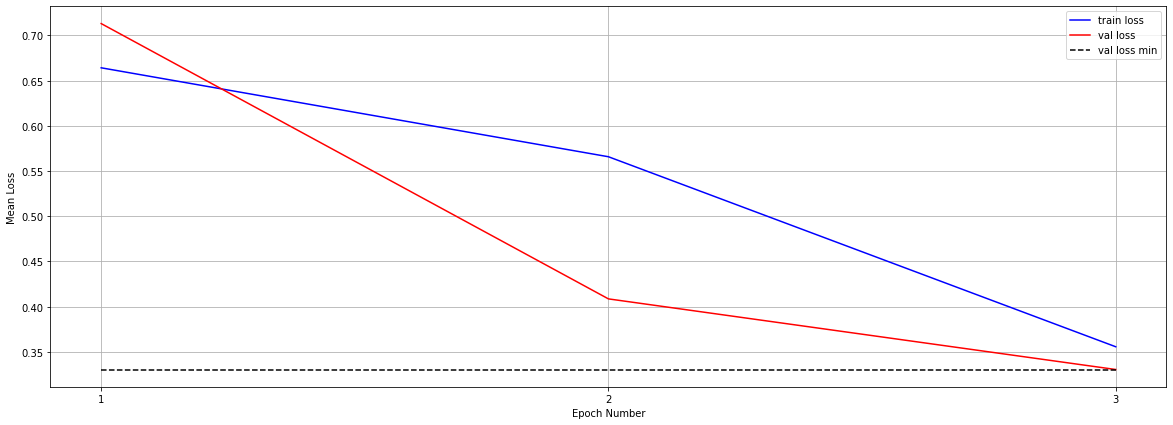

In [35]:
utils.make_loss_plot(loss_history,val_loss_min,model_dir)

## Evaluate model

In [36]:
results = {}

names = 'train val test'.split()

loaders = [train_loader,val_loader,test_loader]
num_batches = 10e3

val_loss = []
for name,loader in zip(names,loaders):
    results[name] = {}
    eval_loss = []
    batch_idx = 0
    num_correct = 0
    total = 0
    for inputs,lengths,labels in loader:
        if batch_idx < num_batches:
            model.eval()
            h = model.init_hidden()
            inputs, lengths, labels = inputs.to(device), lengths.to(device), labels.to(device)
            probs,h = model(inputs,lengths,h)
            loss = loss_function(probs, labels)
            label = labels[:,1]
            
            if is_cuda:
                pred = probs.argmax(axis=1).cpu().numpy()
                label = labels[:,1].cpu().numpy()
            else:
                pred = probs.argmax(axis=1).detach().numpy()
                label = labels[:,1].detach().numpy()

            correct = pred == label
            num_correct += correct.sum()
            total += label.shape[0]
            
            eval_loss.append(loss.item())

            batch_idx += 1

    mean_loss = round(np.mean(eval_loss),3)
    acc = round(num_correct*100/total,2)

    print(f'----{name} set----'.upper())
    print(f'{name} loss of {mean_loss}')
    print(f'{name} accuracy of {acc}')

    results[name]['mean_loss'] = mean_loss
    results[name]['acc'] = acc

utils.save_eval(model_version,results)


----TRAIN SET----
train loss of 0.315
train accuracy of 87.34
----VAL SET----
val loss of 0.33
val accuracy of 86.42
----TEST SET----
test loss of 0.324
test accuracy of 86.8


## Example predictions

In [ ]:
model_dir = '/content/drive/My Drive/colab_data/model_checkpoints/v14'
load_path = os.path.join(model_dir,'glove_lstm_batch.pt')
if is_cuda:
    model.load_state_dict(torch.load(load_path))
else:
    model.load_state_dict(torch.load(load_path,map_location=torch.device('cpu')))

In [ ]:
model_version = 'v16'
model_name = 'glove_lstm_batch.pt'
inf_model = utils.create_inference_model(model_version,model_name,glove,is_cuda,device)

In [ ]:
sentence = 'this movie sucks'.split()
utils.predict_from_inf_model(sentence, word2idx, inf_model, device, is_cuda, return_prob=True)

array([0.805287  , 0.19471297], dtype=float32)

## Start tensorboard

In [ ]:
log_dir

'/content/drive/My Drive/colab_data/model_checkpoints/v14/logs'

In [ ]:
%tensorboard --logdir '/content/drive/My Drive/colab_data/model_checkpoints/v14/logs'

## Grid search

In [22]:
fields = 'model_version hidden p_dropout num_layers num_epochs test_acc test_loss train_acc train_loss'.split()
utils.init_csv(fields)

In [27]:
result = ['v1',50,.1,2,20,.9,1,.9,1]
utils.write_result_row(result)

In [64]:
csv_path = '/content/drive/My Drive/colab_data/grid_search.csv'
res = pd.read_csv(csv_path)

In [65]:
res

,model_version,hidden,p_dropout,num_layers,num_epochs,test_acc,test_loss,train_acc,train_loss
0,v1,50,0.1,2,20,0.90,1.000,0.90,1.000
1,v21,10,0.3,2,20,50.06,0.693,49.96,0.693


,model_version,hidden,p_dropout,num_layers,num_epochs,test_acc,test_loss,train_acc,train_loss


In [85]:
num_labels = 2
vocab_size = 100000
embedding_dim = 300
num_layers = 2
hidden = 50
p_dropout = .3

loss_function = nn.BCELoss()

lr = .001
optimizer = optim.Adam(model.parameters(), lr=lr)

num_epochs = 20

params = {}
params['num_labels'] = num_labels
params['vocab_size'] = vocab_size
params['embedding_dim'] = embedding_dim
params['num_layers'] = num_layers
params['hidden'] = hidden
params['batch_size'] = batch_size
params['p_dropout'] = p_dropout
params['lr'] = lr
params['is_cuda'] = is_cuda
params['device_name'] = device_name
params['num_epochs'] = num_epochs

    
p_dropout_list = [0, .1] #, .2, .3, .4, .5]
hidden_list = [10, 20, 50] #[100] #[50,100] #,200,500,1000] 

grid = [(p_dropout, hidden) for p_dropout in p_dropout_list for hidden in hidden_list]

for grid_idx,(p_dropout,hidden) in enumerate(grid):
    print(f'IDX {grid_idx + 1} / {len(grid)}: SEARCHING p_droput: {p_dropout}, hidden: {hidden}')

    csv_path = '/content/drive/My Drive/colab_data/grid_search.csv'
    res = pd.read_csv(csv_path)
    if len(res[(res.hidden == hidden) & (res.p_dropout == p_dropout)]) != 0:
        print(f'already done')
    else:
        model_version = utils.get_run_version()
        model_dir,log_dir = utils.setup_dir(model_version)

        params['hidden'] = hidden
        params['p_dropout'] = p_dropout

        utils.save_params(model_version,params)

        model = models.lstm_clf_batch(num_labels,vocab_size,embedding_dim,num_layers,hidden,batch_size,glove.vectors,device,p_dropout)
        model.to(device)

        loss_history,val_loss_min = utils.train_model(model_dir,params,train_loader,val_loader,model,model_version,device,is_cuda,loss_function)
        utils.make_loss_plot(loss_history,val_loss_min,model_dir)
        plt.close()
        model = utils.load_model_checkpoint(model_version,is_cuda,model)
        eval_results = utils.eval_model(train_loader,val_loader,test_loader,model,model_version,device,is_cuda,loss_function)

        num_layers = params['num_layers']
        num_epochs = params['num_epochs']

        train_acc = eval_results['train']['acc']
        train_loss = eval_results['train']['mean_loss']

        test_acc = eval_results['test']['acc']
        test_loss = eval_results['test']['mean_loss']

        fields = [model_version,hidden,p_dropout,num_layers,num_epochs,test_acc,test_loss,train_acc,train_loss]
        utils.write_result_row(fields)

IDX 1 / 6: SEARCHING p_droput: 0, hidden: 10
already done
IDX 2 / 6: SEARCHING p_droput: 0, hidden: 20
already done
IDX 3 / 6: SEARCHING p_droput: 0, hidden: 50
50 seconds to train epoch
Epoch 1/20: train loss of 0.649, val loss of 0.653
Val loss decreased inf --> 0.653 saving model...
50 seconds to train epoch
Epoch 2/20: train loss of 0.551, val loss of 0.546
Val loss decreased 0.653 --> 0.546 saving model...
50 seconds to train epoch
Epoch 3/20: train loss of 0.564, val loss of 0.511
Val loss decreased 0.546 --> 0.511 saving model...
50 seconds to train epoch
Epoch 4/20: train loss of 0.384, val loss of 0.343
Val loss decreased 0.511 --> 0.343 saving model...
50 seconds to train epoch
Epoch 5/20: train loss of 0.310, val loss of 0.296
Val loss decreased 0.343 --> 0.296 saving model...
51 seconds to train epoch
Epoch 6/20: train loss of 0.281, val loss of 0.278
Val loss decreased 0.296 --> 0.278 saving model...
50 seconds to train epoch
Epoch 7/20: train loss of 0.265, val loss of 0.

In [86]:
csv_path = '/content/drive/My Drive/colab_data/grid_search.csv'
res = pd.read_csv(csv_path)

In [87]:
res

,model_version,hidden,p_dropout,num_layers,num_epochs,test_acc,test_loss,train_acc,train_loss
0,v22,10,0.0,2,20,89.02,0.275,89.81,0.256
1,v23,20,0.0,2,20,89.76,0.251,91.84,0.213
2,v24,10,0.1,2,20,88.74,0.277,89.31,0.265
3,v25,20,0.1,2,20,90.04,0.246,92.40,0.206
4,v26,50,0.0,2,20,90.44,0.241,93.19,0.184
5,v27,50,0.1,2,20,90.65,0.235,92.50,0.197


## Heatmap

In [88]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [102]:
hidden_values = res.hidden.nunique()
p_dropout_values = res.p_dropout.nunique()

matrix = np.zeros((hidden_values,p_dropout_values))
res_sorted = res.sort_values(['hidden','p_dropout']).copy()

test_acc = res_sorted.test_acc.values
test_acc = test_acc.reshape(matrix.shape)

train_acc = res_sorted.train_acc.values
train_acc = train_acc.reshape(matrix.shape)

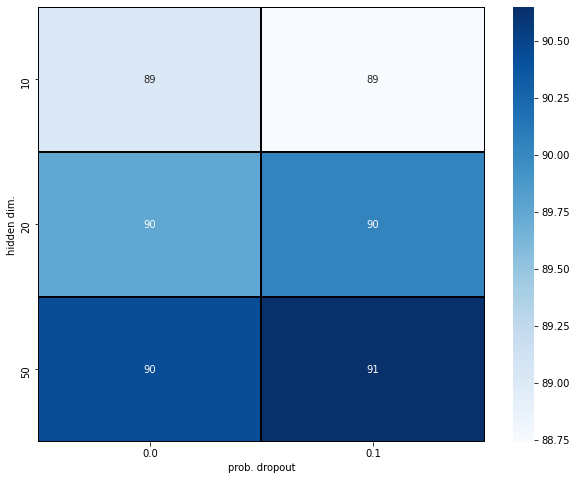

In [105]:
_ = sns.heatmap(test_acc,cmap='Blues',linecolor='black',linewidths=1,annot=True)
fig,ax = plt.gcf(),plt.gca()
_ = ax.set_xlabel('prob. dropout')
_ = ax.set_ylabel('hidden dim.')

_ = ax.set_xticklabels(res.p_dropout.unique())
_ = ax.set_yticklabels(res.hidden.unique())

fig.set_size_inches(10,8)

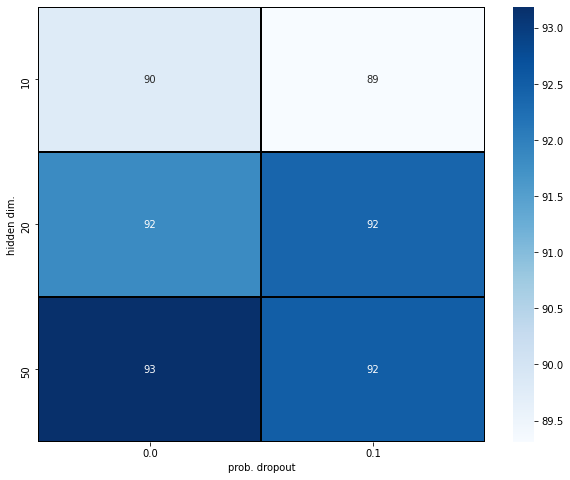

In [106]:
_ = sns.heatmap(train_acc,cmap='Blues',linecolor='black',linewidths=1,annot=True)
fig,ax = plt.gcf(),plt.gca()
_ = ax.set_xlabel('prob. dropout')
_ = ax.set_ylabel('hidden dim.')

_ = ax.set_xticklabels(res.p_dropout.unique())
_ = ax.set_yticklabels(res.hidden.unique())

fig.set_size_inches(10,8)